In [158]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [100]:
df = pd.read_csv('0-1000.csv', index_col='id')
df = df.drop(columns=['error', 'duration'])
df0 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
2,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,0.086539,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,0.259404,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,0.251127,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,0.304533,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
20,0.245351,0.239747,0.211342,0.181047,0.184478,0.177384,0.142504,0.206317,0.242042,0.226818,...,0.333991,0.285059,0.176683,0.181024,0.188473,0.168699,0.164692,0.181571,0.183699,0.000000


# Preprocessing

In [104]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

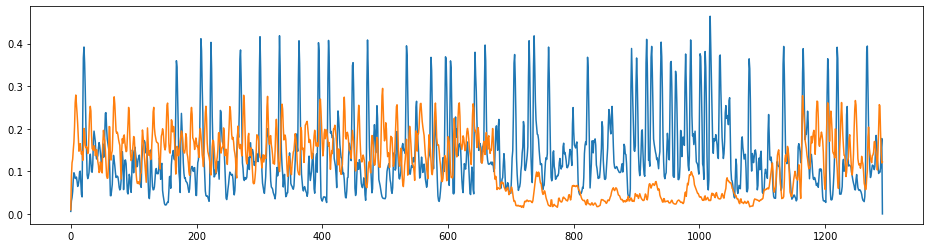

In [105]:
plt.figure(figsize=(16, 4))

ts1 = df[df.index==2].T.values
ts2 = df[df.index==3].T.values

plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Amplitude Scaling

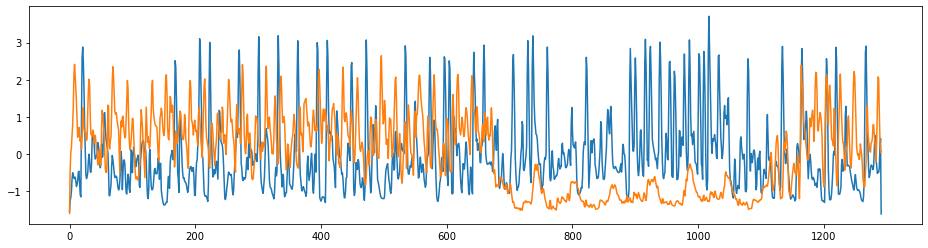

In [106]:
plt.figure(figsize=(16, 4))

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)  # Rescale time series
ts1_scaled = scaler.fit_transform(ts1.reshape(1, -1)).flatten()
ts2_scaled = scaler.fit_transform(ts2.reshape(1, -1)).flatten()

plt.plot(ts1_scaled)
plt.plot(ts2_scaled)
plt.show()

## Noise (smoothing)

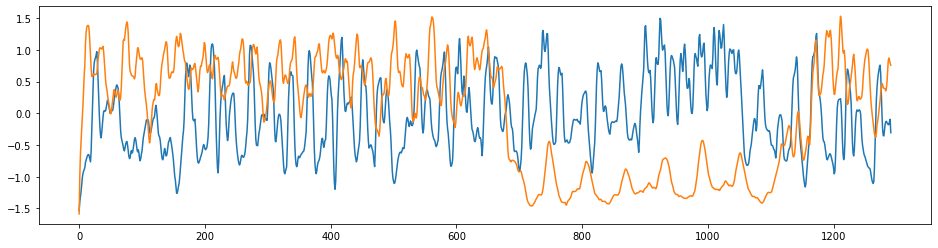

In [108]:
plt.figure(figsize=(16, 4))
w = 10

ts1_ = pd.Series(ts1.reshape(1, -1).squeeze())
ts2_ = pd.Series(ts2.reshape(1, -1).squeeze())

plt.plot(((ts1_ - ts1_.mean())/ts1_.std()).rolling(window=w, min_periods=1).mean())
plt.plot(((ts2_ - ts2_.mean())/ts2_.std()).rolling(window=w, min_periods=1).mean())
plt.show()

In [109]:
#Amplitude scaling
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten())
df = df.T

In [110]:
#Noise
w = 10
df = df.T.apply(lambda x: ((x - x.mean())/x.std()).rolling(window=w, min_periods=1).mean())
df = df.T

In [139]:
indici_rock  = df0[df0["TRACK_genre_top"] == "Rock"].index
indici_experimental  = df0[df0["TRACK_genre_top"] == "Experimental"].index

In [141]:
df_rock = df[df.index.isin(indici_rock)]
df_experimental = df[df.index.isin(indici_experimental)]
df_unito = df_rock.append(df_experimental)

In [143]:
df_unito

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
135,-6.044036,-4.462003,-3.306846,-2.700960,-2.377533,-2.205966,-2.148636,-2.102180,-2.038535,-2.001301,...,-0.402426,-0.563946,-0.747529,-0.801307,-0.799578,-0.792726,-0.765927,-0.761256,-0.793199,-1.467247
136,-5.147179,-3.752938,-2.880933,-2.484722,-2.163133,-1.853487,-1.579883,-1.412333,-1.232967,-1.051050,...,0.156740,0.225047,0.243858,0.226036,0.228036,0.237918,0.115621,0.027092,0.044710,-0.612315
151,-0.547088,-0.091767,0.285127,0.439133,0.466033,0.473745,0.562260,0.631647,0.694721,0.751097,...,-1.737822,-1.720058,-1.697508,-1.711695,-1.730366,-1.730746,-1.728477,-1.731693,-1.746094,-1.760230
152,-2.600645,-2.152051,-1.806554,-1.584359,-1.328259,-1.095367,-0.844264,-0.580085,-0.369298,-0.221828,...,-0.195781,-0.244644,-0.381334,-0.520390,-0.591340,-0.643564,-0.553247,-0.239342,0.000879,0.004620
153,-2.461382,-2.005646,-1.709046,-1.500426,-1.289104,-1.034887,-0.721478,-0.490495,-0.365688,-0.289378,...,0.997171,1.077427,1.118750,1.079857,1.072122,1.214524,1.322568,1.208752,1.131065,0.959259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,-0.430250,-0.257951,-0.133500,-0.067263,-0.000119,0.043098,0.059371,0.094110,0.155916,0.212023,...,-0.331811,-0.315067,-0.359330,-0.449112,-0.486146,-0.485448,-0.473880,-0.476685,-0.496640,-0.517761
1266,-1.483064,-1.342276,-1.199607,-1.117319,-1.120339,-1.202602,-1.278532,-1.341166,-1.402313,-1.445311,...,0.970992,0.947868,0.920938,0.913088,0.955445,1.038181,1.065175,1.071294,1.104153,0.794296
1267,-0.168235,-0.136807,-0.125197,-0.084151,-0.028222,0.007115,0.066453,0.069937,0.106477,0.231844,...,0.584381,0.650032,0.671659,0.771727,0.932497,1.048872,1.117437,1.182965,1.268961,0.901683


# Clustering

## Shape-based Clustering

In [111]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

In [150]:
#X = df_unito.values
X = df.values

In [151]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=5, random_state=0)

In [152]:
km.cluster_centers_.shape

(3, 1292, 1)

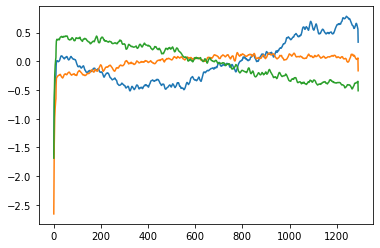

In [153]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [154]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2], dtype=int64), array([188, 521, 291], dtype=int64))

In [155]:
km.inertia_

696.572795017103

In [118]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

KeyboardInterrupt: 

In [ ]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [ ]:
km_dtw.labels_

In [ ]:
km_dtw.inertia_

In [159]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

## Features-based Clustering

In [156]:
from sklearn.cluster import KMeans

In [160]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [163]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(n_clusters=3)

In [164]:
kmeans.inertia_

181.79962872324805

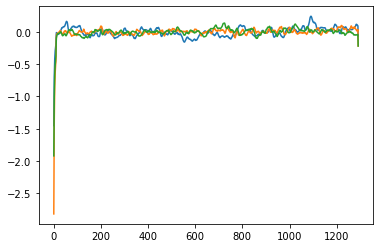

In [165]:
for i in range(3):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()